# 数据获取和处理

这个notebook包含了数据获取和处理的完整流程，分为三个主要部分：
1. 数据获取 - 从数据库获取行业指数数据
2. 数据处理 - 将原始数据转换为可用于量化模型的特征
3. 因子计算和模型训练 - 使用传统逐步回归方法计算因子值并进行回测

## 第一部分：数据获取

In [8]:
# 导入必要的库
import pyodbc
import pandas as pd
import numpy as np
import datetime
import time
from config import *
import warnings
warnings.filterwarnings('ignore')

# 设置路径
root_path_str = 'C:\\Users\\20560\\Desktop\\Code'
save_path = 'data/'


In [1]:
# 数据库连接函数
def fetch_data(sql_query, col_name, uid='feusrfh', pwd='feusrfh'):
    """
    从SQL Server数据库获取数据
    
    Parameters:
    -----------
    sql_query : str
        SQL查询语句
    col_name : list
        列名列表
    uid : str
        用户名
    pwd : str
        密码
        
    Returns:
    --------
    pd.DataFrame
        查询结果数据框
    """
    sqlsv = "SQL Server"
    conn = pyodbc.connect(
        f'DRIVER={sqlsv};SERVER=109.244.74.214,4108;UID={uid};PWD={pwd}')
    cursor = conn.cursor()
    
    # 构建完整的查询语句
    sql_query_plus = '''SELECT * FROM OPENQUERY(WANDE, \'''' + sql_query + '''\')'''
    
    print(f"执行查询: {sql_query[:100]}...")
    cursor.execute(sql_query_plus)
    slctd_data = cursor.fetchall()
    conn.close()
    
    # 转换为DataFrame
    tmp_df = pd.DataFrame([list(x) for x in slctd_data], columns=col_name)
    print(f"获取到 {len(tmp_df)} 行数据")
    
    return tmp_df

In [ ]:
# 获取行业指数基本信息
print("获取行业指数基本信息...")

citics_codename = ['idxCode', 'idxName', 'listDate', 'pblShr', 'idxStyle']
sql_citics_codename = """SELECT distinct
        a.S_INFO_WINDCODE sectorCode,
        REPLACE(b.S_INFO_NAME, '(中信)', '') sectorName,
        b.S_INFO_LISTDATE lstDate,
        b.S_INFO_PUBLISHER pblshr,
        b.S_INFO_INDEXSTYLE idxStyle
        FROM wande.dbo.AINDEXMEMBERSCITICS a
        LEFT JOIN wande.dbo.AINDEXDESCRIPTIONZL b
        on a.S_INFO_WINDCODE = b.S_INFO_WINDCODE
        ORDER BY a.S_INFO_WINDCODE"""
df_idx_citics_info = fetch_data(sql_citics_codename, citics_codename)

# 修复最后一个行业的信息
df_idx_citics_info.values[-1, [1, 2]] = np.array(['综合金融', '20191201'])

print("\n行业指数基本信息:")
display(df_idx_citics_info.head())
print(f"总共 {len(df_idx_citics_info)} 个行业")

# 保存数据
df_idx_citics_info.to_csv(root_path_str + save_path + 'idx_citics_info.csv', encoding='GB18030', index=False)
print("行业指数基本信息已保存")

In [ ]:
# 获取行业指数日线数据
print("获取行业指数日线数据...")

name_idx_citics_data = ['idxCode', 'traDt', 'opnPrice', 'hghPrice', 'lowPrice', 'clsPrice', 'amt', 'volume']
sql_citics_data = """select
        a.S_INFO_WINDCODE idxCode,
        a.TRADE_DT traDt,
        a.S_DQ_OPEN opnPrice,
        a.S_DQ_HIGH hghPrice,
        a.S_DQ_LOW lowPrice,
        a.S_DQ_CLOSE clsPrice,
        a.S_DQ_AMOUNT amt,
        S_DQ_VOLUME volume
        from wande.dbo.AINDEXINDUSTRIESEODCITICS a
        WHERE substring(a.S_INFO_WINDCODE,6,3) < '100'
        order by a.S_INFO_WINDCODE, a.TRADE_DT"""

df_idx_citics_data = fetch_data(sql_citics_data, name_idx_citics_data)

print("\n行业指数日线数据:")
display(df_idx_citics_data.head())
print(f"数据时间范围: {df_idx_citics_data['traDt'].min()} 到 {df_idx_citics_data['traDt'].max()}")
print(f"总数据量: {len(df_idx_citics_data)} 行")

# 保存数据
df_idx_citics_data.to_csv(root_path_str + save_path + 'idx_citics_data.csv', encoding='GB18030', index=False)
print("行业指数日线数据已保存")

In [ ]:
# 查看数据统计信息
print("数据统计信息:")
print(f"行业数量: {len(df_idx_citics_info)}")
print(f"交易天数: {len(df_idx_citics_data['traDt'].unique())}")
print(f"每个行业的平均数据量: {len(df_idx_citics_data) / len(df_idx_citics_info):.0f} 行")

# 检查数据完整性
print("\n数据完整性检查:")
missing_data = df_idx_citics_data.isnull().sum()
if missing_data.sum() > 0:
    print("发现缺失值:")
    display(missing_data[missing_data > 0])
else:
    print("数据完整，无缺失值")

# 查看行业列表
print("\n行业列表:")
for i, industry in enumerate(df_idx_citics_info['idxName']):
    print(f"{i+1:2d}. {industry}")

## 第二部分：数据处理

In [16]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("数据处理开始...")

数据处理开始...


In [17]:
print("读取行业信息数据...")
idx_info_data = pd.read_csv(root_path_str + 'data/idx_citics_info.csv', encoding='GB18030')
print(f"行业信息数据: {idx_info_data.shape}")
display(idx_info_data.head())

print("\n读取行业指数数据...")
idx_data = pd.read_csv(root_path_str + 'data/idx_citics_data.csv', encoding='gb18030')
print(f"行业指数数据: {idx_data.shape}")
display(idx_data.head())

读取行业信息数据...
行业信息数据: (30, 5)


,idxCode,idxName,listDate,pblShr,idxStyle
0,CI005001.WI,石油石化,20100629,中信证券股份有限公司,NaN
1,CI005002.WI,煤炭,20100629,中信证券股份有限公司,NaN
2,CI005003.WI,有色金属,20100629,中信证券股份有限公司,NaN
3,CI005004.WI,电力及公用事业,20100629,中信证券股份有限公司,NaN
4,CI005005.WI,钢铁,20100629,中信证券股份有限公司,NaN



读取行业指数数据...
行业指数数据: (147354, 8)


,idxCode,traDt,opnPrice,hghPrice,lowPrice,clsPrice,amt,volume
0,CI005001.WI,20041231,1000.0000,1000.0000,1000.0000,1000.0000,NaN,NaN
1,CI005001.WI,20050104,989.8004,997.8338,945.8514,972.6953,328129.6714,710751.65
2,CI005001.WI,20050105,971.9548,983.1995,959.8703,972.4125,180328.2547,395558.41
3,CI005001.WI,20050106,964.0736,969.5403,942.0239,953.4392,147641.5074,318729.12
4,CI005001.WI,20050107,945.7154,970.1929,938.1744,954.5805,125341.2835,270313.82


数据透视
数据透视后形状: (5009, 29)
时间范围: 2004-12-31 00:00:00 到 2025-08-14 00:00:00
行业数量: 29


,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
2004-12-31,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,...,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000,1000.0000
2005-01-04,972.6953,971.6588,974.9029,983.8077,976.2269,984.1301,985.7494,988.6503,984.3312,983.9793,...,990.2624,984.9190,971.4580,993.1926,986.6346,992.7887,989.8816,997.8527,1001.2205,997.1057
2005-01-05,972.4125,976.6908,988.5014,993.2399,983.7726,994.4515,1001.7736,1003.5723,997.8509,999.6678,...,1005.2765,975.7218,991.0295,1018.1711,996.0323,1009.8923,1005.5461,1026.2292,1040.0349,1019.9167
2005-01-06,953.4392,957.3087,965.2290,979.5781,969.9842,983.2128,993.2242,990.7411,994.4649,991.6098,...,994.1639,965.1899,992.4178,1017.2031,992.8979,1001.3624,989.5672,1024.9278,1039.1674,1013.4837
2005-01-07,954.5805,920.7459,963.1241,977.8708,969.1005,985.9675,1000.5584,994.2298,998.8018,990.2740,...,1001.1542,965.4274,1000.2445,1035.1659,991.2206,1018.5846,990.8038,1021.6451,1034.9097,1019.1937


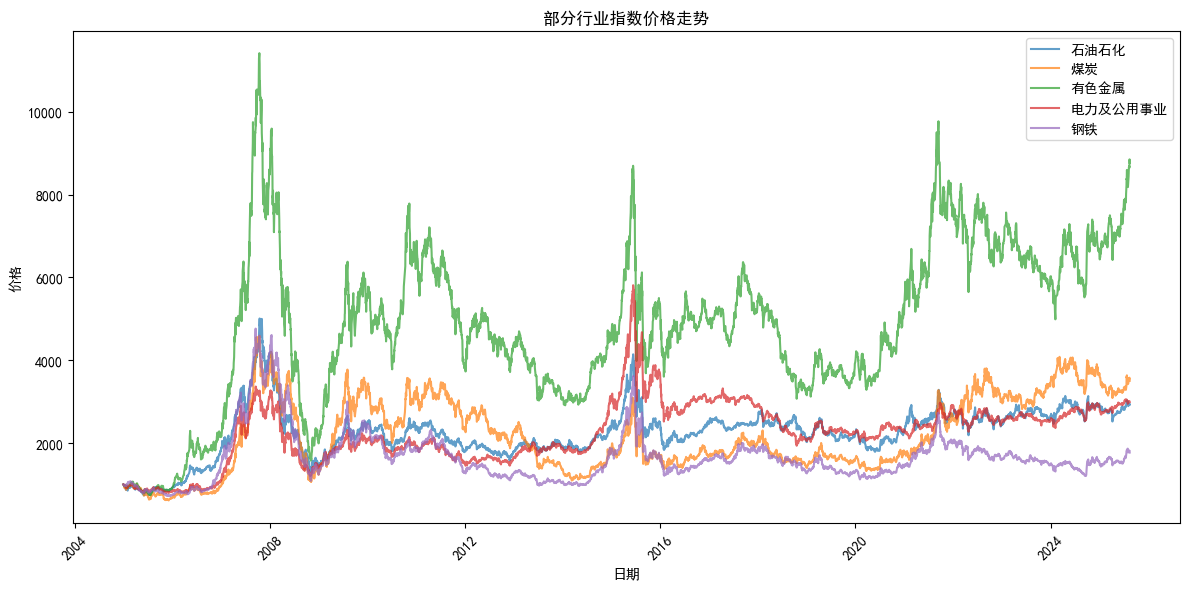

In [ ]:
print("数据透视")

# 创建行业名称映射字典
idx_name = [i for i in idx_info_data.idxName]
name_dict = dict(zip(idx_info_data.idxCode.values, idx_name))

# 将长格式数据转换为宽格式
idx_daily_price = idx_data.pivot(index='traDt', columns='idxCode', values='clsPrice')
idx_daily_price.columns = [name_dict[i] for i in idx_daily_price.columns]
idx_daily_price.index = [pd.to_datetime(str(i)) for i in idx_daily_price.index]

# 移除综合金融行业
idx_daily_price.drop('综合金融', axis=1, inplace=True)

print(f"数据透视后形状: {idx_daily_price.shape}")
print(f"时间范围: {idx_daily_price.index.min()} 到 {idx_daily_price.index.max()}")
print(f"行业数量: {idx_daily_price.shape[1]}")

display(idx_daily_price.head())

# 可视化部分行业价格走势
plt.figure(figsize=(12, 6))
for col in idx_daily_price.columns[:5]:  # 只显示前5个行业
    plt.plot(idx_daily_price.index, idx_daily_price[col], label=col, alpha=0.7)
plt.title('部分行业指数价格走势')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

生成行业配对数据
总共需要生成 406 个配对
配对数据形状: (5009, 406)


,石油石化/煤炭,石油石化/有色金属,石油石化/电力及公用事业,石油石化/钢铁,石油石化/基础化工,石油石化/建筑,石油石化/建材,石油石化/轻工制造,石油石化/机械,石油石化/电力设备,...,电子元器件/通信,电子元器件/计算机,电子元器件/传媒,电子元器件/综合,通信/计算机,通信/传媒,通信/综合,计算机/传媒,计算机/综合,传媒/综合
2004-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2005-01-04,1.001067,0.997736,0.988705,0.996382,0.988381,0.986757,0.983862,0.988179,0.988532,0.992396,...,1.002937,0.994925,0.991578,0.995670,0.992012,0.988675,0.992755,0.996636,1.000749,1.004127
2005-01-05,0.995620,0.983724,0.979031,0.988453,0.977838,0.970691,0.968951,0.974507,0.972736,0.978013,...,1.004322,0.984081,0.971018,0.990171,0.979846,0.966839,0.985910,0.986726,1.006189,1.019725
2005-01-06,0.995958,0.987785,0.973316,0.982943,0.969718,0.959944,0.962349,0.958746,0.961506,0.967558,...,1.011920,0.977008,0.963620,0.988040,0.965499,0.952269,0.976402,0.986297,1.011292,1.025342
2005-01-07,1.036747,0.991129,0.976183,0.985017,0.968166,0.954048,0.960121,0.955726,0.963956,0.969291,...,1.028039,0.997004,0.984226,0.999402,0.969812,0.957382,0.972145,0.987183,1.002405,1.015420


配对数据已保存


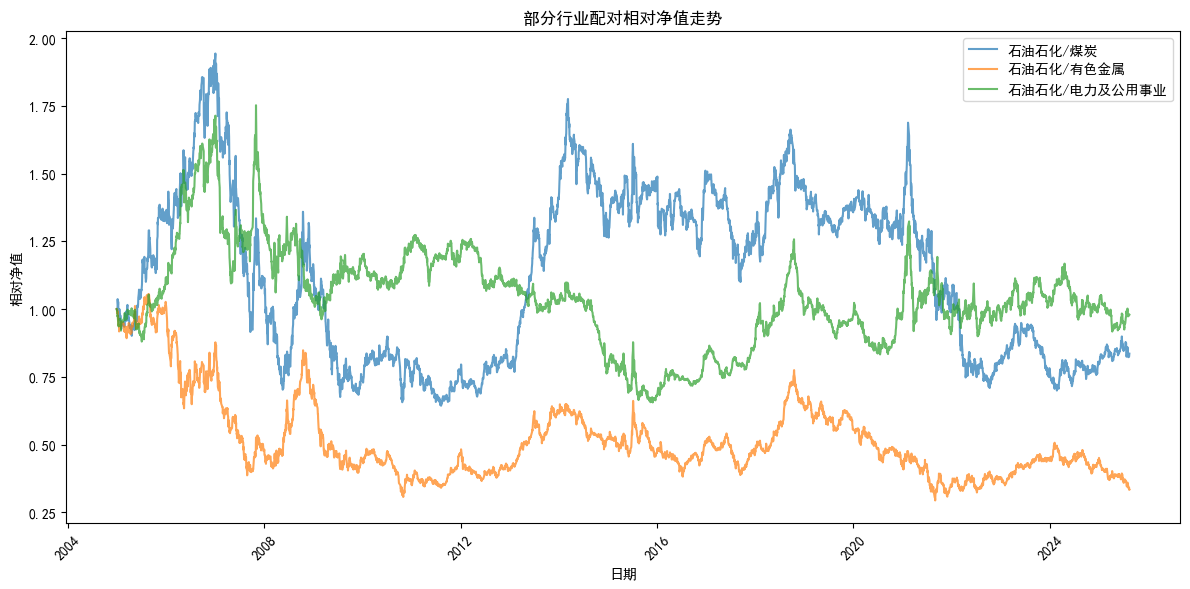

In [19]:
print("生成行业配对数据")

col_list = list(idx_daily_price.columns)
result = []
pair_name_list = []

print(f"总共需要生成 {len(col_list) * (len(col_list) - 1) // 2} 个配对")

# 生成所有两两配对
for i in range(idx_daily_price.shape[1] - 1):
    left_idx = idx_daily_price.iloc[:, i]
    for j in range(i + 1, idx_daily_price.shape[1]):
        right_idx = idx_daily_price.iloc[:, j]
        curr_pair = left_idx / right_idx  # 计算相对净值
        curr_pair.name = col_list[i] + '/' + col_list[j]
        result.append(curr_pair)
        pair_name_list.append([col_list[i], col_list[j]])

all_pair_df = pd.DataFrame(result).T
pair_name_df = pd.DataFrame(pair_name_list, columns=['left', 'right'])

print(f"配对数据形状: {all_pair_df.shape}")
display(all_pair_df.head())

# 保存配对数据
pair_name_df.to_csv(root_path_str + save_path + 'pair_name.csv', index=False, encoding='GB18030')
all_pair_df.to_csv(root_path_str + save_path + 'pair_nv.csv', encoding='GB18030')

# 生成月度数据
all_pair_monthly = all_pair_df.resample('M').last()
all_pair_monthly.to_csv(root_path_str + save_path + 'pair_nv_monthly.csv', encoding='GB18030')

print("配对数据已保存")

# 可视化部分配对走势
plt.figure(figsize=(12, 6))
for col in all_pair_df.columns[:3]:  # 只显示前3个配对
    plt.plot(all_pair_df.index, all_pair_df[col], label=col, alpha=0.7)
plt.title('部分行业配对相对净值走势')
plt.xlabel('日期')
plt.ylabel('相对净值')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

计算收益率数据...
日收益率数据形状: (5009, 29)
月度收益率数据形状: (249, 29)
超额收益率数据形状: (248, 29)


,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,-0.139690,-0.095245,-0.080745,-0.088131,-0.015821,-0.063275,-0.071149,-0.066128,-0.083446,-0.048162,...,-0.080687,-0.014896,-0.151644,0.005202,-0.048573,-0.083556,-0.018882,-0.095807,-0.075477,-0.084641
2005-02-28,0.119650,0.130761,0.141099,0.078857,0.074207,0.107023,0.114503,0.099195,0.067891,0.119321,...,0.103889,0.065740,0.122011,0.079023,0.072900,0.194960,0.075152,0.091352,0.105189,0.087571
2005-03-31,-0.082533,-0.107633,-0.111822,-0.088172,-0.097204,-0.068936,-0.146377,-0.138937,-0.117231,-0.099243,...,-0.116173,-0.087225,-0.188932,-0.128411,-0.026963,-0.146794,-0.160760,-0.156435,-0.139923,-0.153942
2005-04-30,-0.019008,0.015134,-0.017263,-0.009859,-0.101365,-0.004672,-0.062489,-0.106926,-0.039307,-0.022792,...,-0.061226,0.088066,0.073853,-0.041588,0.030122,-0.120486,-0.096441,-0.129527,-0.126376,-0.091439


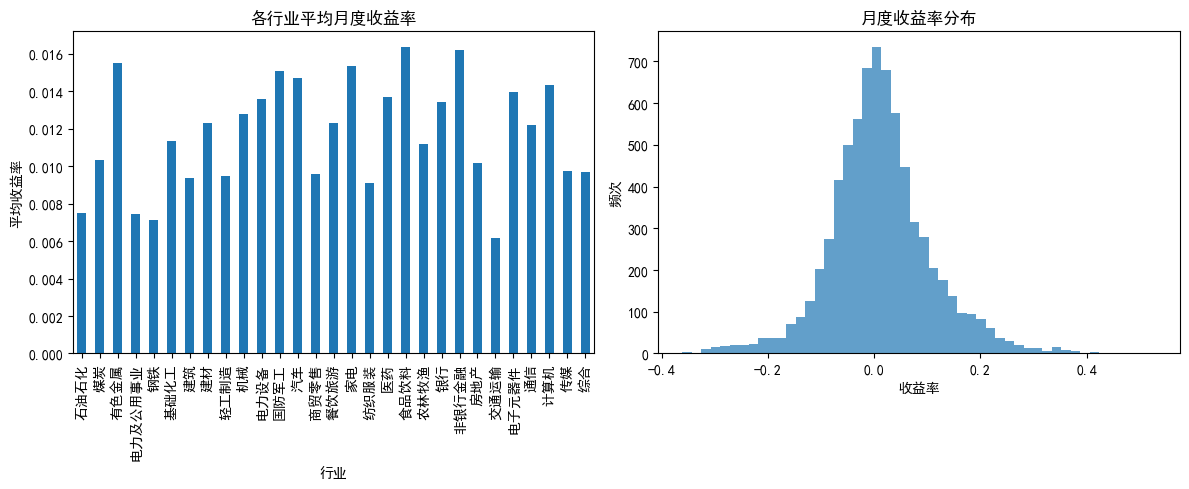

In [20]:
# 计算收益率数据
print("计算收益率数据...")

# 日收益率
idx_daily_ror = (idx_daily_price / idx_daily_price.shift(1) - 1)
equal_weight_daily_ror = idx_daily_ror.mean(axis=1)
equal_weight_daily_nv = (equal_weight_daily_ror.fillna(0) + 1).cumprod()

# 月度收益率
idx_monthly_price = idx_daily_price.resample('M').last()
idx_monthly_ror = idx_monthly_price / idx_monthly_price.shift(1) - 1

# 行业超额收益率（相对等权组合）
idx_relative_ror = idx_monthly_ror.apply(lambda x: x - x.mean(), axis=1).dropna()

print(f"日收益率数据形状: {idx_daily_ror.shape}")
print(f"月度收益率数据形状: {idx_monthly_ror.shape}")
print(f"超额收益率数据形状: {idx_relative_ror.shape}")

display(idx_monthly_ror.head())

# 可视化月度收益率分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
idx_monthly_ror.mean().plot(kind='bar')
plt.title('各行业平均月度收益率')
plt.xlabel('行业')
plt.ylabel('平均收益率')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.hist(idx_monthly_ror.values.flatten(), bins=50, alpha=0.7)
plt.title('月度收益率分布')
plt.xlabel('收益率')
plt.ylabel('频次')

plt.tight_layout()
plt.show()

In [ ]:

# 读取宏观因子数据
print("读取宏观因子数据...")

try:
    # 尝试读取标记数据
    factor = pd.read_excel(root_path_str + '\\标记-数值数据.xlsx', sheet_name='标记数据', index_col=0)
    print(f"标记数据形状: {factor.shape}")
    display(factor.head())
except Exception as e:
    print(f"读取标记数据失败: {e}")
    factor = pd.DataFrame()

try:
    # 尝试读取数值数据
    # 在 .iloc[:, :-1] 之后添加 .resample('M').last()
    dt = pd.read_excel(root_path_str + '\\标记-数值数据.xlsx', sheet_name='变量值', index_col=0).iloc[:, :-1].resample('M').last()
    print(f"数值数据形状: {dt.shape}")
    display(dt.head())
except Exception as e:
    print(f"读取数值数据失败: {e}")
    dt = pd.DataFrame()

if len(factor) > 0 and len(dt) > 0:
    print("\n宏观因子数据读取成功！")
else:
    print("\n警告：宏观因子数据读取失败，请检查文件路径和格式")

读取宏观因子数据...
标记数据形状: (191, 16)


,房地产开发投资完成额:累计同比标记,CPI:当月同比标记,PPI:当月同比标记,中债国债到期收益率:10年标记,信用利差标记,期限利差标记,EP（万得全A（除金融）市盈率倒数）标记,DP（上证红利指数股息率）标记,上证指数过去一个月波动率标记,工业增加值标记,实际GDP标记,名义GDP标记,M1标记,M2标记,社融增速标记,CRB现货指数:综合:月标记
时间,,,,,,,,,,,,,,,,
2010-02-28,1,1,1,-1,-1,-1,1,1,1,-1,1,1,-1,-1,-1,1
2010-03-31,1,1,1,-1,-1,-1,1,1,1,-1,1,1,-1,-1,-1,1
2010-04-30,1,1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,-1,-1,1
2010-05-31,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1
2010-06-30,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1


数值数据形状: (194, 15)


,房地产开发投资完成额:累计同比,CPI:当月同比,PPI:当月同比,中债国债到期收益率:10年,信用利差,期限利差,EP（万得全A（除金融）市盈率倒数）,DP（上证红利指数股息率）,上证指数过去一个月波动率,工业增加值,实际GDP,名义GDP,M1,M2,社融增速
时间,,,,,,,,,,,,,,,
2010-02-28,0.311,0.027,0.0539,0.034749,0.010224,0.018167,0.015709,0.024955,0.212604,20.7,11.500000,16.742783,34.99,25.52,46.884088
2010-03-31,0.351,0.024,0.0591,0.034062,0.010256,0.018810,0.017795,0.024235,0.161759,18.1,11.900000,18.278246,29.94,22.50,41.314302
2010-04-30,0.362,0.028,0.0681,0.034520,0.009750,0.018276,0.029049,0.026874,0.205355,17.8,11.366667,18.338820,31.25,21.48,43.451230
2010-05-31,0.382,0.031,0.0713,0.032604,0.008620,0.015224,0.031593,0.041993,0.307462,16.5,10.833333,18.399394,29.90,21.00,40.429473
2010-06-30,0.381,0.029,0.0641,0.033186,0.008014,0.013202,0.034523,0.033610,0.288280,13.7,10.300000,18.459968,24.56,18.46,35.240433



宏观因子数据读取成功！


开始处理宏观因子数据...
清理后标记数据形状: (191, 16)
清理后数值数据形状: (192, 15)
处理后宏观因子数据形状: (187, 31)


,房地产开发投资完成额:累计同比差分,CPI:当月同比差分,PPI:当月同比差分,中债国债到期收益率:10年差分,信用利差差分,期限利差差分,EP（万得全A（除金融）市盈率倒数）差分,DP（上证红利指数股息率）差分,上证指数过去一个月波动率差分,工业增加值差分,...,EP（万得全A（除金融）市盈率倒数）标记,DP（上证红利指数股息率）标记,上证指数过去一个月波动率标记,工业增加值标记,实际GDP标记,名义GDP标记,M1标记,M2标记,社融增速标记,CRB现货指数:综合:月标记
时间,,,,,,,,,,,,,,,,,,,,,
2010-06-30,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-07-31,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-08-31,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-09-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-10-31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0


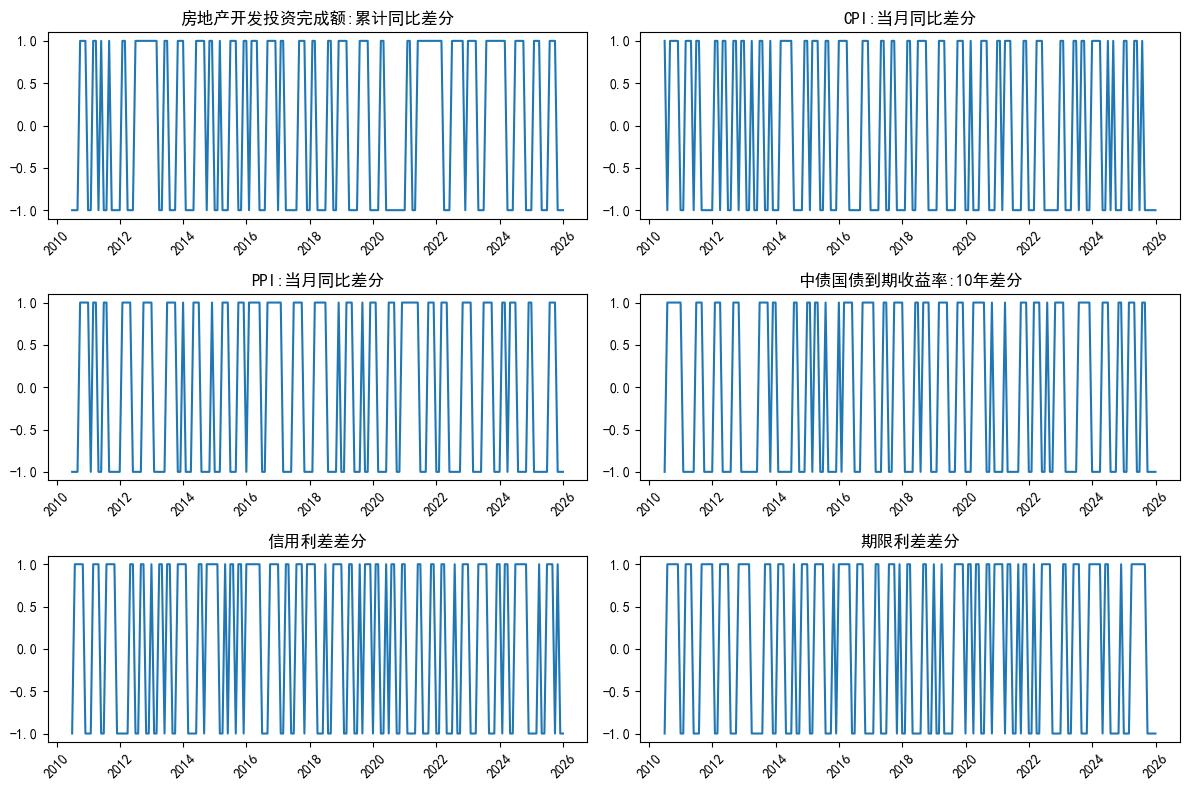

In [21]:
# 处理宏观因子数据
if len(factor) > 0 and len(dt) > 0:
    print("开始处理宏观因子数据...")
    
    # 数据预处理
    factor.dropna(inplace=True)
    data_1 = factor.copy()
    data_2 = dt.copy()
    
    print(f"清理后标记数据形状: {data_1.shape}")
    print(f"清理后数值数据形状: {data_2.shape}")
    
    # 计算两个月差分
    dt = dt - dt.shift(+2)
    dt.dropna(how='all', inplace=True)
    
    # 生成标记变量
    data = pd.DataFrame(index=dt.index)
    for i in dt.columns:
        data[i + '差分'] = dt[i].apply(lambda x: +1 if x > 0 else -1)
    
    # 合并标记数据
    data = pd.concat([data, factor], axis=1)
    data.dropna(inplace=True)
    
    print(f"处理后宏观因子数据形状: {data.shape}")
    display(data.head())
    
    # 可视化部分宏观因子
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(data.columns[:6]):
        plt.subplot(3, 2, i+1)
        plt.plot(data.index, data[col])
        plt.title(col)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("跳过宏观因子数据处理")

In [22]:
def add_data(data, names, data2, t):
    """
    添加时间序列特征到数据中
    """
    for name in names:
        if name in data2.columns:
            data[name + t] = np.array(data2[name])

In [ ]:
# 构建时间序列特征
if len(data) > 0:
    print("构建时间序列特征...")
    
    # 定义需要排除的当期估值指标
    back_factor = ['EP（万得全A（除金融）市盈率倒数）标记', 'EP（万得全A（除金融）市盈率倒数）差分', 
                   'DP（上证红利指数股息率）标记', 'DP（上证红利指数股息率）差分', 
                   '上证指数过去一个月波动率标记', '上证指数过去一个月波动率差分']
    back = ['EP（万得全A（除金融）市盈率倒数）标记', 'DP（上证红利指数股息率）标记', 
            '上证指数过去一个月波动率标记']
    
    all_factors = list(data.columns)
    fore_factor = all_factors.copy()
    
    # 移除当期指标
    for b in back_factor:
        if b in fore_factor:
            fore_factor.remove(b)
    for q in back:
        if q in all_factors:
            all_factors.remove(q)
    
    print(f"领先期因子数量: {len(fore_factor)}")
    print(f"全期因子数量: {len(all_factors)}")
    
    # 构建不同时间期的数据
    l = len(data)
    f3 = data.iloc[6:l, :]   # +3期
    f2 = data.iloc[5:l-1, :] # +2期
    f1 = data.iloc[4:l-2, :] # +1期
    f0 = data.iloc[3:l-3, :] # 当期
    m1 = data.iloc[2:l-4, :] # -1期
    m2 = data.iloc[1:l-5, :] # -2期
    m3 = data.iloc[:l-6, :]  # -3期
    
    # 构建特征矩阵
    fac = f0[fore_factor].copy()
    
    # 添加未来数据（避免未来函数）
    add_data(fac, fore_factor, f3, '+3')
    add_data(fac, fore_factor, f2, '+2')
    add_data(fac, fore_factor, f1, '+1')
    add_data(fac, all_factors, m1, '-1')
    add_data(fac, all_factors, m2, '-2')
    add_data(fac, all_factors, m3, '-3')
    
    # 确保index是每月月末
    fac = fac.resample('M').last()
    
    print(f"最终特征矩阵形状: {fac.shape}")
    display(fac.head())
else:
    print("跳过时间序列特征构建")



构建时间序列特征...
领先期因子数量: 25
全期因子数量: 28
最终特征矩阵形状: (181, 184)


,房地产开发投资完成额:累计同比差分,CPI:当月同比差分,PPI:当月同比差分,中债国债到期收益率:10年差分,信用利差差分,期限利差差分,工业增加值差分,实际GDP差分,名义GDP差分,M1差分,...,中债国债到期收益率:10年标记-3,信用利差标记-3,期限利差标记-3,工业增加值标记-3,实际GDP标记-3,名义GDP标记-3,M1标记-3,M2标记-3,社融增速标记-3,CRB现货指数:综合:月标记-3
时间,,,,,,,,,,,,,,,,,,,,,
2010-09-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-10-31,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-11-30,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2010-12-31,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,...,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0


生成月度效应特征...
月度效应特征形状: (181, 12)


,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月
时间,,,,,,,,,,,,
2010-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2010-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2010-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


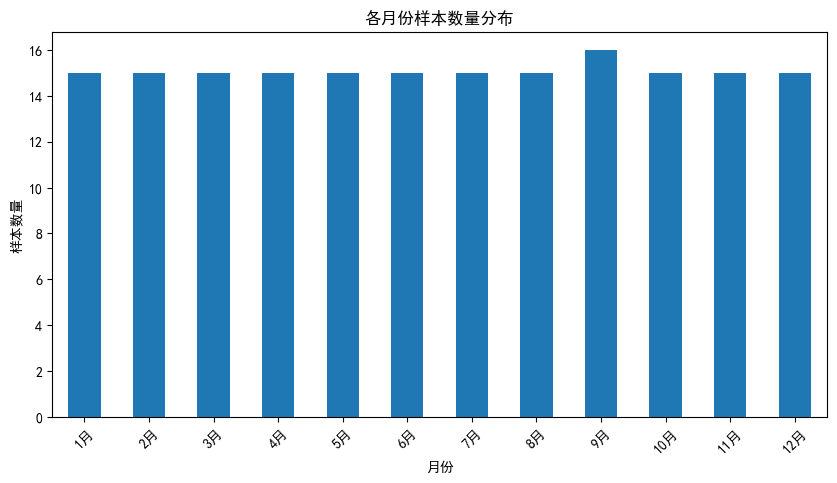

In [24]:
# 生成月度效应特征
if len(fac) > 0:
    print("生成月度效应特征...")
    
    # 生成月度虚拟变量
    month = pd.get_dummies(fac.index.month)
    month.columns = ["{}月".format(i) for i in range(1, 13)]
    month.index = fac.index
    month = month.astype('float64')
    
    print(f"月度效应特征形状: {month.shape}")
    display(month.head())
    
    # 可视化月度效应
    plt.figure(figsize=(10, 5))
    month.sum().plot(kind='bar')
    plt.title('各月份样本数量分布')
    plt.xlabel('月份')
    plt.ylabel('样本数量')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("跳过月度效应特征生成")

准备最终的模型输入数据...
共同时间范围: 2010-09-30 00:00:00 到 2025-08-31 00:00:00
样本数量: 180
因变量数据形状: (180, 29)
宏观因子数据形状: (180, 184)
月度效应数据形状: (180, 12)

数据已保存到文件:
- data/Y_data.xlsx (因变量: 行业超额收益率)
- data/X_data.xlsx (自变量: 宏观因子 + 月度效应)
- data/idx_monthly_abs_ror.xlsx (行业绝对收益率)

数据统计信息:
样本期间: 2010-09-30 到 2025-08-31
样本数量: 180 个月
行业数量: 29 个
宏观因子数量: 184 个


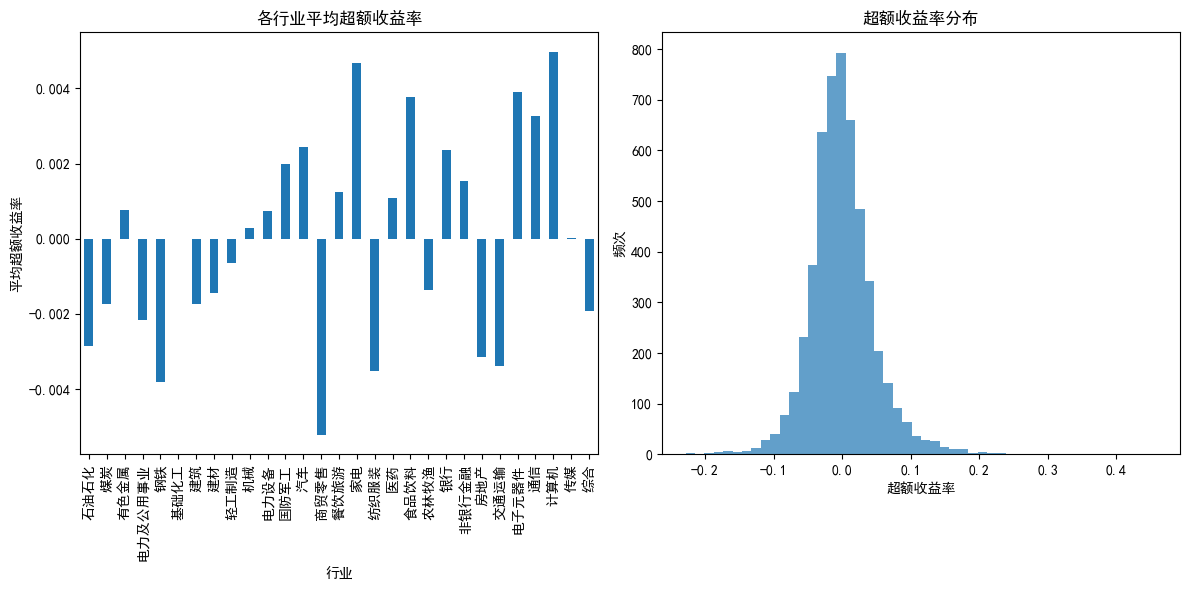

In [25]:
# 准备最终的模型输入数据
if len(fac) > 0 and len(idx_relative_ror) > 0:
    print("准备最终的模型输入数据...")
    
    # 找到共同的时间索引
    common_index = fac.index.intersection(idx_relative_ror.index)
    print(f"共同时间范围: {common_index.min()} 到 {common_index.max()}")
    print(f"样本数量: {len(common_index)}")
    
    # 准备因变量（Y）
    Y_data = idx_relative_ror.loc[common_index]
    
    # 准备自变量（X）
    X_macro = fac.loc[common_index]
    X_month = month.loc[common_index]
    
    print(f"因变量数据形状: {Y_data.shape}")
    print(f"宏观因子数据形状: {X_macro.shape}")
    print(f"月度效应数据形状: {X_month.shape}")
    
    # 保存数据
    Y_data.to_excel(root_path_str + save_path + 'Y_data.xlsx')
    
    writer = pd.ExcelWriter(root_path_str + save_path + 'X_data.xlsx')
    X_macro.to_excel(writer, sheet_name='macro')
    X_month.to_excel(writer, sheet_name='month_effect')
    pd.Series(all_factors).to_excel(writer, sheet_name='factor_name')
    writer.close()
    
    # 保存月度绝对收益率
    idx_monthly_ror_common = idx_monthly_ror.loc[common_index]
    idx_monthly_ror_common.to_excel(root_path_str + save_path + 'idx_monthly_abs_ror.xlsx')
    
    print("\n数据已保存到文件:")
    print(f"- {save_path}Y_data.xlsx (因变量: 行业超额收益率)")
    print(f"- {save_path}X_data.xlsx (自变量: 宏观因子 + 月度效应)")
    print(f"- {save_path}idx_monthly_abs_ror.xlsx (行业绝对收益率)")
    
    # 显示数据统计信息
    print("\n数据统计信息:")
    print(f"样本期间: {common_index.min().strftime('%Y-%m-%d')} 到 {common_index.max().strftime('%Y-%m-%d')}")
    print(f"样本数量: {len(common_index)} 个月")
    print(f"行业数量: {Y_data.shape[1]} 个")
    print(f"宏观因子数量: {X_macro.shape[1]} 个")
    
    # 可视化因变量分布
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    Y_data.mean().plot(kind='bar')
    plt.title('各行业平均超额收益率')
    plt.xlabel('行业')
    plt.ylabel('平均超额收益率')
    plt.xticks(rotation=90)
    
    plt.subplot(1, 2, 2)
    plt.hist(Y_data.values.flatten(), bins=50, alpha=0.7)
    plt.title('超额收益率分布')
    plt.xlabel('超额收益率')
    plt.ylabel('频次')
    
    plt.tight_layout()
    plt.show()
else:
    print("数据准备失败，无法生成最终模型输入数据")

## 第三部分：因子计算和模型训练

In [26]:
import statsmodels.api as sm
from tqdm import tqdm
from joblib import Parallel, delayed
import os
from dateutil.relativedelta import relativedelta
import sys

print("因子计算开始...")

因子计算开始...


In [41]:
robust = 0.10
max_num = 5
all_factors = pd.read_excel(root_path_str + 'data/X_data.xlsx', index_col=0, sheet_name='factor_name').iloc[:,
              0].values.tolist()

In [42]:
def forward(x_data, y_data, mon):
    result = []
    rresult = []
    x_names = list(x_data.columns)
    # all_factors
    flag = True
    while flag:
        if len(result) == 0:
            pass
        else:
            t = result[-1]
            x_names.remove(result[-1])
            kill = []
            if t in all_factors:
                key = t
            elif t[:-2] in all_factors:
                key = t[:-2]
            for i in x_names:
                if (i[:-2] == key) or (i == key):
                    kill.append(i)
                elif (i[:-2] == key) or (i[:-2] == key[:-2]):
                    kill.append(i)
                elif (i[:-4] == key) or (i[:-4] == key[:-2]):
                    kill.append(i)
            for k in kill:
                x_names.remove(k)
        res = []
        rres = []
        parres = []
        if len(x_names) > 0:
            for name in x_names:
                new_list = result.copy()
                new_list.append(name)
                new_x = x_data[new_list]
                x = sm.add_constant(new_x)
                model = sm.OLS(y_data, x)
                results = model.fit()
                p_value = results.pvalues.iloc[-1]
                r_value = results.rsquared
                res.append(p_value)
                rres.append(r_value)
            min_value = np.min(res)
            min_index = np.argmin(res)
            r = rres[min_index]
            if min_value > robust:
                flag = False
            else:
                result.append(x_names[min_index])
                rresult.append(r)
            if len(result) == 5:
                flag = False
        else:
            flag = False
    # after finish
    if len(result) > 0:
        new_x = x_data[result]
        x = sm.add_constant(new_x)
        model = sm.OLS(y_data, x)
        results = model.fit()
        par = list(results.params)
        if len(par) > len(result):
            value = par[0]
            del par[0]
            result.append('常数项')
            par.append(value)
            rresult.append(rresult[-1])
    else:
        par = []
    if len(result) < max_num + 1:
        ad = max_num + 1 - len(result)
        for i in range(ad):
            result.append(0)
            par.append(0)
            rresult.append(0)
    # 残差对月度变量回归
    res = results.resid
    mmodel = sm.OLS(res, mon)
    mresults = mmodel.fit()
    mresult = list(mon.columns)
    mpar = list(mresults.params)
    return result, par, rresult, mresult, mpar

In [43]:
def rotation(x_data, y_data, m, y_name):
    factor = {}
    factorm = {}
    x = x_data.copy()
    y = y_data.copy()
    m_ = m.copy()
    result, par, rresult, mresult, mpar = forward(x, y, m_)
    factor[y_name] = result
    factor[y_name + '回归参数'] = par
    factor[y_name + 'r^2'] = rresult
    factorm[y_name] = mresult
    factorm[y_name + '回归参数'] = mpar
    return factor, factorm

In [44]:
def procedure_for_single_pair(i, macro_x_train_all, month_x_train_all, y_train, para, mute_num, this_month_end):
    curr_pair = y_train.columns[i]
    y_train_single_idx = y_train.loc[:, curr_pair]
    data_dict = pd.DataFrame()
    curr_ed_dt = macro_x_train_all.index[-1]
    look_back_period = para
    for i in range(look_back_period):
        temp_ed_dt = pd.offsets.MonthEnd().rollforward(curr_ed_dt + relativedelta(months=-i))
        temp_macro_x_train = macro_x_train_all.loc[macro_x_train_all.index <= temp_ed_dt, :]
        temp_month_x_train = month_x_train_all.loc[month_x_train_all.index <= temp_ed_dt, :]
        temp_y_train = y_train_single_idx.loc[y_train_single_idx.index <= temp_ed_dt]
        temp_factor, temp_factor_m = rotation(temp_macro_x_train, temp_y_train, temp_month_x_train, curr_pair)
        # data_dict = data_dict.append(pd.DataFrame(temp_factor).T)
        data_dict = pd.concat([data_dict, pd.DataFrame(temp_factor).T])
    res = []
    res_dict = {}
    check = data_dict.loc[curr_pair, :]
    if look_back_period > 1:
        for j in range(look_back_period):
            res.extend(list(check.loc[curr_pair, :].values[j]))
    else:
        res.extend(list(check.values))
    while 0 in res:
        res.remove(0)
    for name in sorted(set(res)):
        res_dict[str(name)] = res.count(name)
    if '0' in res_dict.keys():
        del res_dict['0']
    if '常数项' in res_dict.keys():
        del res_dict['常数项']
    if len(res_dict.keys()) == 0:
        factor = []
    else:
        key_list = list(res_dict.keys())
        value_list = list(res_dict.values())
        candidate_sr = pd.Series(value_list, index=key_list)
        # 统计只出现一次的变量数量
        stat_once_appear = (candidate_sr == 1).sum()
        if stat_once_appear != len(candidate_sr):
            candidate_sr = candidate_sr.loc[candidate_sr > 1].sort_values()
        else:
            candidate_sr = candidate_sr.sort_values()
        if len(candidate_sr) <= 5:
            factor = candidate_sr.index.values.tolist()
        else:
            factor = candidate_sr.index[-5:].values.tolist()
    # 再回归一次
    if factor != []:
        new_x = macro_x_train_all.loc[:, factor]
        new_y = y_train_single_idx
        m = month_x_train_all
        x = sm.add_constant(new_x)
        model = sm.OLS(new_y, x)
        results = model.fit()
        par = list(results.params)
        if len(par) > len(factor):
            factor.append('常数项')
            c = par[0]
            del par[0]
            par.append(c)
        if len(par) < 6:
            for i in range(6 - len(par)):
                factor.append(0)
                par.append(0)
    else:
        factor = [0, 0, 0, 0, 0, 0]
        par = [0, 0, 0, 0, 0, 0]
        print('{0}{1}有问题'.format(curr_pair, curr_ed_dt))
    # 再做一次回归
    res = results.resid
    mmodel = sm.OLS(res, m)
    mresults = mmodel.fit()
    factorm = list(m.columns)
    parm = mresults.params
    result_dict = {}
    resultm_dict = {}
    time = this_month_end.strftime('%Y%m%d')
    result_dict[time + curr_pair] = factor
    result_dict[time + curr_pair + '回归参数'] = par
    resultm_dict[time + curr_pair] = factorm
    resultm_dict[time + curr_pair + '回归参数'] = parm
    # 输出模型
    output_dict = {}
    output_list = []
    output_list.append(pd.DataFrame(result_dict).T)
    output_list.append(pd.DataFrame(resultm_dict).T)
    output_dict[curr_pair] = output_list
    return output_dict

In [45]:
def train_model(this_month_end, y, macro_x, month_x, rolling_or_expanding, para, mute_num, rolling_window=10):
    # 对数据进行时间对齐操作，保证训练使用数据全部为训练时点可得数据，具体实现方式为：
    # 使用的train_data的dataframe截止时间要比this_month_end当前月底提前5个月，首先由于我们使用的宏观数据的滞后披露属性，当月只能拿到两个月前的完整数据，其次因为dataframe中包含了index时点的未来三个月数据，所以一共是提前5个月
    train_end_tp = pd.offsets.MonthEnd().rollforward(this_month_end + relativedelta(months=-5))
    if rolling_or_expanding == 'expanding':
        macro_x_train_all = macro_x.loc[macro_x.index <= train_end_tp, :]
        month_x_train_all = month_x.loc[month_x.index <= train_end_tp, :]
        y_train_all = y.loc[y.index <= train_end_tp, :]
    elif rolling_or_expanding == 'rolling':
        rolling_start_tp = pd.offsets.MonthEnd().rollforward(train_end_tp + relativedelta(years=-rolling_window))
        macro_x_train_all = macro_x.loc[(macro_x.index <= train_end_tp) & (macro_x.index >= rolling_start_tp), :]
        month_x_train_all = month_x.loc[(month_x.index <= train_end_tp) & (month_x.index >= rolling_start_tp), :]
        y_train_all = y.loc[(y.index <= train_end_tp) & (y.index >= rolling_start_tp), :]
    # 如果设置验证集的话
    """
    val_time_start = this_month_end + relativedelta(months=-12)
    macro_x_val = macro_x.loc[(macro_x.index >= val_time_start) & (macro_x.index <= this_month_end), :]
    month_x_val = month_x.loc[(month_x.index >= val_time_start) & (month_x.index <= this_month_end), :]
    y_val = y.loc[(y.index >= val_time_start) & (y.index <= this_month_end), :]
    """
    cpu_num = os.cpu_count() - 1
    # cpu_num = 1
    all_pair_output_result = Parallel(cpu_num)(
        delayed(procedure_for_single_pair)(i, macro_x_train_all, month_x_train_all, y_train_all, para, mute_num,
                                           this_month_end) for i
        in tqdm(range(len(y_train_all.columns))))
    # 先进行变量选择，然后将选择出的变量和月度效应一起拟合模型
    return all_pair_output_result

In [46]:
def cal_win_rate(x, true_factor_value):
    nona_x = x[~pd.isnull(x)]
    true_factor_slice = true_factor_value.loc[x.name, nona_x.index]
    return (nona_x == true_factor_slice).sum() / nona_x.shape[0]


In [47]:
def cal_max_retreat(base_ratio):
    cumu_ratio = np.cumprod(base_ratio + 1)
    return -np.min(cumu_ratio / pd.DataFrame(cumu_ratio).cummax().values.ravel() - 1)

In [48]:
def cal_portfolio_stat(end_portfolio_revenue_sr, base_revenue_sr):
    end_portfolio_revenue = end_portfolio_revenue_sr.values
    base_revenue = base_revenue_sr.values
    outperform_ror = end_portfolio_revenue - base_revenue
    cumu_ratio = np.cumprod(1 + end_portfolio_revenue)
    cumu_base_ratio = np.cumprod(1 + base_revenue)
    revenue_yearly = cumu_ratio[-1] ** (12 / len(end_portfolio_revenue)) - 1
    base_revenue_yearly = cumu_base_ratio[-1] ** (12 / len(base_revenue)) - 1
    out_perform_nv = cumu_ratio / cumu_base_ratio
    return [revenue_yearly * 100, np.std(end_portfolio_revenue) * np.sqrt(12) * 100,
            cal_max_retreat(end_portfolio_revenue) * 100,
            revenue_yearly / (np.std(end_portfolio_revenue) * np.sqrt(12)),
            revenue_yearly / cal_max_retreat(end_portfolio_revenue),
            np.sum(outperform_ror > 0) * 100 / outperform_ror.shape[0],
            (out_perform_nv[-1] ** (12 / len(end_portfolio_revenue)) - 1) * 100]


In [49]:
# 输入因子值df（月频），股票收益率df（月频），返回月度滚动窗口回测结果, 可以用来测试个股因子和行业因子，只需要industry_or_stk填写'行业','个股'即可
def single_factor_back_test(factor_df, stk_df, num_of_group, start_date, end_date, base_revenue_df, industry_or_stk,
                            industry_or_stk_constraint):
    nona_factor = factor_df.copy()
    nona_factor = nona_factor.loc[(nona_factor.index >= start_date) & (nona_factor.index <= end_date)]
    nona_stk = stk_df.copy()
    nona_stk = nona_stk.loc[(nona_stk.index >= start_date) & (nona_stk.index <= end_date)]
    common_index = nona_factor.index.intersection(nona_stk.index)
    # 每个月的因子值用来选下个月的股，所以测试时候的因子值时间区间终点要小于 股票时间区间终点
    if common_index[-1] < nona_stk.index[-1]:
        temp_append = nona_stk.index.where(nona_stk.index > common_index[-1])
        common_index = common_index.append(pd.to_datetime([temp_append[~pd.isnull(temp_append)][0]]))
    strategy_date = [common_index[0]]
    strategy_revenue = []
    equal_weight_revenue = [0]
    group_portfolio = []
    if industry_or_stk_constraint is None:
        with_or_without_constraint = False
    else:
        with_or_without_constraint = True
    for i in range(num_of_group):
        strategy_revenue.append([0])
        group_portfolio.append([])
    for iter_x in range(len(common_index) - 1):
        factor_date = common_index[iter_x]
        if with_or_without_constraint:
            needed_delete_industry_or_stk = industry_or_stk_constraint.columns[
                industry_or_stk_constraint.loc[factor_date, :]].values
        factor_value = nona_factor.loc[factor_date, :].copy()
        # 保留非空因子值Series
        factor_value = factor_value.loc[~pd.isnull(factor_value)]
        stk_date = common_index[iter_x + 1]
        all_avail_stk = nona_stk.loc[stk_date, :]
        all_avail_stk = all_avail_stk.loc[~pd.isnull(all_avail_stk)]
        common_stk = factor_value.index.intersection(all_avail_stk.index)
        factor_value = factor_value.loc[common_stk]
        factor_value.sort_values(ascending=False, inplace=True)
        if industry_or_stk == '行业':
            equal_weight_revenue.append(np.mean(all_avail_stk.values))
        elif industry_or_stk == '个股':
            equal_weight_revenue.append(base_revenue_df.loc[stk_date, base_revenue_df.columns[0]])
        else:
            return None
        for iter_group in range(num_of_group):
            long_stk = factor_value.index[int(factor_value.shape[0] * iter_group / num_of_group):int(
                factor_value.shape[0] * (iter_group + 1) / num_of_group)]
            if with_or_without_constraint:
                long_stk = np.setdiff1d(long_stk, needed_delete_industry_or_stk)
            stk_value = nona_stk.loc[stk_date, long_stk]
            strategy_revenue[iter_group].append(np.mean(stk_value.values))
            if with_or_without_constraint:
                group_portfolio[iter_group].append(factor_value.loc[long_stk].sort_values(ascending=False).index.values)
            else:
                group_portfolio[iter_group].append(long_stk.values)
        strategy_date.append(stk_date)
    col_name = ['第{}组'.format(i + 1) for i in range(num_of_group)]
    strategy_revenue_df = pd.DataFrame(np.array(strategy_revenue).T, index=strategy_date, columns=col_name)
    strategy_portfolio_df = pd.DataFrame(group_portfolio, index=col_name, columns=strategy_date[1:]).T
    equal_weight_revenue_sr = pd.Series(equal_weight_revenue, index=strategy_date)
    strategy_revenue_df['等权'] = equal_weight_revenue_sr
    stat_df = strategy_revenue_df.iloc[1:, :].apply(cal_portfolio_stat,
                                                    args=(equal_weight_revenue_sr.iloc[1:],),
                                                    axis=0)
    stat_df.index = ['年化收益率%', '年化波动率%', '最大回撤%', '夏普比率', '卡玛比率', '调仓胜率%', '超额收益%']
    strategy_net_value = (strategy_revenue_df + 1).cumprod(axis=0)
    return strategy_portfolio_df, strategy_revenue_df, strategy_net_value, stat_df.T

In [50]:
def output_backtest_table(factor_data, monthly_revenue, num_of_group, start_date, end_date, base_revenue_df,
                          industry_or_stk, table_name, industry_or_stk_constraint):
    common_stk = np.intersect1d(factor_data.columns, monthly_revenue.columns)
    strategy_portfolio_df, strategy_revenue_df, strategy_net_value, stat_df = single_factor_back_test(
        factor_data.loc[:, common_stk], monthly_revenue.loc[:, common_stk], num_of_group, start_date, end_date,
        base_revenue_df, industry_or_stk, industry_or_stk_constraint)
    if industry_or_stk == '行业':
        out_perform_nv = strategy_net_value['第1组'] / strategy_net_value['等权']
        strategy_net_value['空头超额'] = strategy_net_value.iloc[:, -2] / strategy_net_value['等权']
        strategy_net_value['多头超额'] = out_perform_nv
        yearly_outperform_nv = out_perform_nv.resample('Y').last()
        yearly_outperform_ror = yearly_outperform_nv / yearly_outperform_nv.shift(1) - 1
        yearly_outperform_ror = yearly_outperform_ror.loc[yearly_outperform_ror.index >= '2010/12/31']
    writer = pd.ExcelWriter(table_name)
    strategy_portfolio_df.to_excel(writer, sheet_name='分组持仓')
    strategy_revenue_df.to_excel(writer, sheet_name='组合月收益')
    strategy_net_value.to_excel(writer, sheet_name='组合净值')
    stat_df.to_excel(writer, sheet_name='评价指标')
    if industry_or_stk == '行业':
        yearly_outperform_ror.to_excel(writer, sheet_name='分年超额')
    writer.close()

In [51]:
def roll_df_index(df):
    pair_rank = df.copy()
    pair_rank.loc[pd.offsets.MonthEnd().rollforward(pair_rank.index[0] + relativedelta(months=-1)), :] = np.nan
    pair_rank.sort_index(inplace=True)
    return pair_rank.shift(-1).dropna()


In [ ]:
# --- 模型参数 ---
root_path_str = 'C:\\Users\\20560\\Desktop\\Code\\' 
para = 6
mute_num = 2
model_name = 'linear_regression'
window_kind = 'expanding'
train_interval = 1
start_dt = '20181231'
end_dt = '20250731'

# --- 加载数据 ---
print("加载 Y_data...")
Y_data = pd.read_excel(root_path_str + 'data/Y_data.xlsx', index_col=0)
print(Y_data.info())
display(Y_data.head())

print("\n加载 X_data_macro...")
X_data_macro = pd.read_excel(root_path_str + 'data/X_data.xlsx', index_col=0, sheet_name='macro')
print(X_data_macro.info())
display(X_data_macro.head())

print("\n加载 X_data_month...")
X_data_month = pd.read_excel(root_path_str + 'data/X_data.xlsx', index_col=0, sheet_name='month_effect')
print(X_data_month.info())
display(X_data_month.head())

# 对齐 Y_data 的起始时间
Y_data = Y_data.loc[Y_data.index >= X_data_macro.index.min(), :]
print(f"\n数据加载并对齐完成。Y_data 的新起始时间: {Y_data.index.min().strftime('%Y-%m-%d')}")

正在加载 Y_data...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2005-01-31 to 2025-07-31
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   石油石化     247 non-null    float64
 1   煤炭       247 non-null    float64
 2   有色金属     247 non-null    float64
 3   电力及公用事业  247 non-null    float64
 4   钢铁       247 non-null    float64
 5   基础化工     247 non-null    float64
 6   建筑       247 non-null    float64
 7   建材       247 non-null    float64
 8   轻工制造     247 non-null    float64
 9   机械       247 non-null    float64
 10  电力设备     247 non-null    float64
 11  国防军工     247 non-null    float64
 12  汽车       247 non-null    float64
 13  商贸零售     247 non-null    float64
 14  餐饮旅游     247 non-null    float64
 15  家电       247 non-null    float64
 16  纺织服装     247 non-null    float64
 17  医药       247 non-null    float64
 18  食品饮料     247 non-null    float64
 19  农林牧渔     247 non-null    float64
 20  银行       247 non-nul

,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
2005-01-31,-0.070475,-0.026030,-0.011530,-0.018916,0.053393,0.005940,-0.001935,0.003087,-0.014231,0.021053,...,-0.011472,0.054318,-0.082429,0.074417,0.020642,-0.014341,0.050333,-0.026592,-0.006262,-0.015426
2005-02-28,0.016233,0.027344,0.037682,-0.024560,-0.029210,0.003606,0.011086,-0.004222,-0.035526,0.015904,...,0.000472,-0.037677,0.018594,-0.024394,-0.030517,0.091543,-0.028265,-0.012065,0.001772,-0.015846
2005-03-31,0.032237,0.007136,0.002948,0.026598,0.017565,0.045834,-0.031607,-0.024167,-0.002461,0.015527,...,-0.001404,0.027544,-0.074163,-0.013641,0.087807,-0.032024,-0.045991,-0.041666,-0.025154,-0.039172
2005-04-30,0.019978,0.054120,0.021723,0.029127,-0.062380,0.034313,-0.023504,-0.067941,-0.000321,0.016193,...,-0.022240,0.127052,0.112838,-0.002603,0.069107,-0.081501,-0.057456,-0.090542,-0.087391,-0.052453
2005-05-31,-0.050025,-0.074434,-0.041399,-0.006226,0.009521,-0.053045,0.020211,0.025657,0.020891,-0.030852,...,0.005976,-0.000174,0.003152,-0.026254,-0.048885,0.037018,0.024774,0.055458,0.041473,0.025822



正在加载 X_data_macro...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2010-07-31 to 2025-09-30
Columns: 184 entries, 房地产开发投资完成额:累计同比差分 to CRB现货指数:综合:月标记-3
dtypes: int64(184)
memory usage: 264.5 KB
None


,房地产开发投资完成额:累计同比差分,CPI:当月同比差分,PPI:当月同比差分,中债国债到期收益率:10年差分,信用利差差分,期限利差差分,工业增加值差分,实际GDP差分,名义GDP差分,M1差分,...,中债国债到期收益率:10年标记-3,信用利差标记-3,期限利差标记-3,工业增加值标记-3,实际GDP标记-3,名义GDP标记-3,M1标记-3,M2标记-3,社融增速标记-3,CRB现货指数:综合:月标记-3
时间,,,,,,,,,,,,,,,,,,,,,
2010-07-31,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,1
2010-08-31,-1,1,-1,-1,-1,1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,1
2010-09-30,-1,1,-1,1,1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,1
2010-10-31,-1,1,1,1,1,1,-1,-1,-1,1,...,1,-1,-1,-1,-1,1,-1,-1,-1,1
2010-11-30,1,1,1,1,1,1,-1,1,1,1,...,1,1,-1,-1,-1,1,-1,-1,-1,1



正在加载 X_data_month...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2010-07-31 to 2025-09-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1月      183 non-null    bool 
 1   2月      183 non-null    bool 
 2   3月      183 non-null    bool 
 3   4月      183 non-null    bool 
 4   5月      183 non-null    bool 
 5   6月      183 non-null    bool 
 6   7月      183 non-null    bool 
 7   8月      183 non-null    bool 
 8   9月      183 non-null    bool 
 9   10月     183 non-null    bool 
 10  11月     183 non-null    bool 
 11  12月     183 non-null    bool 
dtypes: bool(12)
memory usage: 3.6 KB
None


,1月,2月,3月,4月,5月,6月,7月,8月,9月,10月,11月,12月
时间,,,,,,,,,,,,
2010-07-31,False,False,False,False,False,False,True,False,False,False,False,False
2010-08-31,False,False,False,False,False,False,False,True,False,False,False,False
2010-09-30,False,False,False,False,False,False,False,False,True,False,False,False
2010-10-31,False,False,False,False,False,False,False,False,False,True,False,False
2010-11-30,False,False,False,False,False,False,False,False,False,False,True,False



数据加载并对齐完成。Y_data 的新起始时间: 2010-07-31


In [ ]:
# 初始化结果容器
start_train_date = pd.to_datetime(start_dt)
avail_end_date = pd.to_datetime(end_dt)

# 初始化用于存储预测因子值的 DataFrame
factor_value = pd.DataFrame(
    index=pd.date_range(pd.offsets.MonthEnd().rollforward(start_train_date + relativedelta(months=1)),
                        pd.offsets.MonthEnd().rollforward(avail_end_date + relativedelta(months=1)), freq='M'),
    columns=Y_data.columns)

# 初始化用于存储模型参数的 DataFrame
macro_sensitivity = pd.DataFrame()
month_effect = pd.DataFrame()

print("用于存储结果的 DataFrame 已创建:")
print(f"factor_value 的形状: {factor_value.shape}")
print(f"factor_value 的时间范围: {factor_value.index.min().strftime('%Y-%m-%d')} 到 {factor_value.index.max().strftime('%Y-%m-%d')}")
display(factor_value.head())

用于存储结果的 DataFrame 已创建:
factor_value 的形状: (80, 29)
factor_value 的时间范围: 2019-01-31 到 2025-08-31


,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
current_train_date = start_train_date
debug_end_date = pd.to_datetime('2025-07-30') 

month_count = 0
while current_train_date <= debug_end_date: 
    month_count += 1
    print(f"--- [第 {month_count} 个月] 训练开始: {current_train_date.strftime('%Y-%m')} ---")
    
    # 练模型
    pair_model_list = train_model(current_train_date, Y_data, X_data_macro, X_data_month, window_kind, para, mute_num)
    
    # 确定预测区间
    next_train_date = pd.offsets.MonthEnd().rollforward(current_train_date + relativedelta(months=train_interval))
    needed_predict_tp = factor_value.index[
        (factor_value.index > current_train_date) & (factor_value.index <= next_train_date)]
    
    print(f"模型训练完成，将对 {needed_predict_tp[0].strftime('%Y-%m')} 进行预测。")

    # 进行预测并填充结果
    for iter_dict in pair_model_list:
        for curr_pair, model_list in iter_dict.items():
            macro_model = model_list[0]
            month_model = model_list[1]
            macro_sensitivity = pd.concat([macro_sensitivity, macro_model])
            month_effect = pd.concat([month_effect, month_model])
            
            var_candidate_sr = pd.Series(macro_model.iloc[1, :].values, index=macro_model.iloc[0, :].values)
            var_candidate_sr = var_candidate_sr.loc[var_candidate_sr.index != 0]
            
            if '常数项' in var_candidate_sr.index:
                const = var_candidate_sr.loc['常数项']
                var_candidate_sr = var_candidate_sr.loc[var_candidate_sr.index != '常数项']
                curr_var = var_candidate_sr.index.values
            else:
                const = 0
                curr_var = var_candidate_sr.index.values
            
            # 检查是否有有效因子被选中
            if len(curr_var) > 0:
                macro_x_test = X_data_macro.loc[needed_predict_tp, curr_var]
                month_x_test = X_data_month.loc[needed_predict_tp, :]
                macro_pre = macro_x_test.dot(var_candidate_sr) + const
                month_pre = month_x_test.dot(month_model.iloc[1, :])
                factor_value.loc[needed_predict_tp, curr_pair] = macro_pre + month_pre

    # 打印当月某个配对选出的因子和预测值 
    if pair_model_list:
        sample_pair = list(pair_model_list[0].keys())[0]
        print(f"  [示例] 配对 '{sample_pair}' 在本月选出的宏观因子: {list(curr_var)}")
        print(f"  [示例] 预测的因子值: {factor_value.loc[needed_predict_tp, sample_pair].values[0]:.4f}")

    # 轮到下一个训练时点
    current_train_date = next_train_date

print("\n--- 循环执行完成 ---")

--- [第 1 个月] 训练开始: 2018-12 ---


100%|██████████| 29/29 [00:00<00:00, 14497.59it/s]


模型训练完成，将对 2019-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '信用利差标记-2', '工业增加值标记+3', '名义GDP标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0296
--- [第 2 个月] 训练开始: 2019-01 ---


100%|██████████| 29/29 [00:00<00:00, 27035.97it/s]


模型训练完成，将对 2019-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['社融增速差分+1', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '名义GDP标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0220
--- [第 3 个月] 训练开始: 2019-02 ---


100%|██████████| 29/29 [00:00<00:00, 28960.67it/s]


模型训练完成，将对 2019-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['房地产开发投资完成额:累计同比标记', '社融增速差分+3', '名义GDP标记+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0195
--- [第 4 个月] 训练开始: 2019-03 ---


100%|██████████| 29/29 [00:00<00:00, 28974.47it/s]


模型训练完成，将对 2019-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP标记+3', '房地产开发投资完成额:累计同比标记', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0026
--- [第 5 个月] 训练开始: 2019-04 ---


100%|██████████| 29/29 [00:00<00:00, 28974.47it/s]


模型训练完成，将对 2019-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP标记+3', '房地产开发投资完成额:累计同比标记', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0111
--- [第 6 个月] 训练开始: 2019-05 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2019-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP标记+3', '房地产开发投资完成额:累计同比标记', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0115
--- [第 7 个月] 训练开始: 2019-06 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2019-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP标记+3', '房地产开发投资完成额:累计同比标记', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0170
--- [第 8 个月] 训练开始: 2019-07 ---


100%|██████████| 29/29 [00:00<00:00, 28953.78it/s]


模型训练完成，将对 2019-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP标记+3', '房地产开发投资完成额:累计同比标记', '社融增速差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0346
--- [第 9 个月] 训练开始: 2019-08 ---


100%|██████████| 29/29 [00:00<00:00, 29218.07it/s]


模型训练完成，将对 2019-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['房地产开发投资完成额:累计同比标记', '社融增速差分', '社融增速差分+3', '期限利差差分-2', 'EP（万得全A（除金融）市盈率倒数）差分-2']
  [示例] 预测的因子值: -0.0465
--- [第 10 个月] 训练开始: 2019-09 ---


100%|██████████| 29/29 [00:00<00:00, 29029.79it/s]


模型训练完成，将对 2019-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差差分-1', '名义GDP差分+3', '工业增加值差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: -0.0218
--- [第 11 个月] 训练开始: 2019-10 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2019-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', '信用利差差分-1', '名义GDP差分+3', '工业增加值差分+3', '期限利差差分-2']
  [示例] 预测的因子值: -0.0165
--- [第 12 个月] 训练开始: 2019-11 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2019-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', '信用利差差分-1', '名义GDP差分+3', '工业增加值差分+3', '期限利差差分-2']
  [示例] 预测的因子值: -0.0131
--- [第 13 个月] 训练开始: 2019-12 ---


100%|██████████| 29/29 [00:00<00:00, 28995.19it/s]


模型训练完成，将对 2020-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差差分-2', 'CPI:当月同比差分', '信用利差差分-1', '名义GDP差分+3', '工业增加值差分+3']
  [示例] 预测的因子值: 0.0315
--- [第 14 个月] 训练开始: 2020-01 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2020-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP差分+3', '名义GDP标记+3', '工业增加值差分+3', '工业增加值标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0190
--- [第 15 个月] 训练开始: 2020-02 ---


100%|██████████| 29/29 [00:00<00:00, 29022.86it/s]


模型训练完成，将对 2020-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['M1标记+3', '信用利差差分-1', '名义GDP标记+3', '工业增加值标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0138
--- [第 16 个月] 训练开始: 2020-03 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2020-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['M1标记+3', '信用利差差分-1', '工业增加值标记+3', '期限利差差分-2', '名义GDP标记+3']
  [示例] 预测的因子值: 0.0379
--- [第 17 个月] 训练开始: 2020-04 ---


100%|██████████| 29/29 [00:00<00:00, 29630.89it/s]


模型训练完成，将对 2020-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['M1标记+3', '信用利差差分-1', '期限利差差分-2', '工业增加值标记+3', '名义GDP标记+3']
  [示例] 预测的因子值: 0.0003
--- [第 18 个月] 训练开始: 2020-05 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2020-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['工业增加值标记+3', 'CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', '信用利差差分-1', '名义GDP标记+3']
  [示例] 预测的因子值: 0.0246
--- [第 19 个月] 训练开始: 2020-06 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2020-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['工业增加值差分+3', 'CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', '信用利差差分-1', '名义GDP标记+3']
  [示例] 预测的因子值: -0.0029
--- [第 20 个月] 训练开始: 2020-07 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2020-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '工业增加值差分+3', 'CPI:当月同比差分', '信用利差差分-1', '名义GDP标记+3']
  [示例] 预测的因子值: -0.0209
--- [第 21 个月] 训练开始: 2020-08 ---


100%|██████████| 29/29 [00:00<00:00, 28995.19it/s]


模型训练完成，将对 2020-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', '信用利差差分-1', '名义GDP标记+3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0065
--- [第 22 个月] 训练开始: 2020-09 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2020-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', '信用利差差分-1', '工业增加值差分+3', '名义GDP标记+3']
  [示例] 预测的因子值: -0.0322
--- [第 23 个月] 训练开始: 2020-10 ---


100%|██████████| 29/29 [00:00<00:00, 29015.94it/s]


模型训练完成，将对 2020-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', '信用利差差分-1', '工业增加值差分+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '名义GDP标记+3']
  [示例] 预测的因子值: -0.0104
--- [第 24 个月] 训练开始: 2020-11 ---


100%|██████████| 29/29 [00:00<00:00, 28974.47it/s]


模型训练完成，将对 2020-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['工业增加值差分+3', '期限利差差分-2', 'CPI:当月同比差分', '名义GDP标记+3', 'EP（万得全A（除金融）市盈率倒数）差分-2']
  [示例] 预测的因子值: 0.0045
--- [第 25 个月] 训练开始: 2020-12 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2021-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差标记+3', '名义GDP标记+3', 'CPI:当月同比差分', '期限利差差分-2', 'EP（万得全A（除金融）市盈率倒数）差分-2']
  [示例] 预测的因子值: 0.0161
--- [第 26 个月] 训练开始: 2021-01 ---


100%|██████████| 29/29 [00:00<00:00, 29015.94it/s]


模型训练完成，将对 2021-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'M2标记+1', '信用利差标记+3', 'EP（万得全A（除金融）市盈率倒数）差分-2', '期限利差差分-2']
  [示例] 预测的因子值: 0.0080
--- [第 27 个月] 训练开始: 2021-02 ---


100%|██████████| 29/29 [00:00<00:00, 19285.69it/s]


模型训练完成，将对 2021-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0053
--- [第 28 个月] 训练开始: 2021-03 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2021-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0120
--- [第 29 个月] 训练开始: 2021-04 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2021-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0070
--- [第 30 个月] 训练开始: 2021-05 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2021-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0214
--- [第 31 个月] 训练开始: 2021-06 ---


100%|██████████| 29/29 [00:00<00:00, 56998.51it/s]


模型训练完成，将对 2021-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', 'EP（万得全A（除金融）市盈率倒数）差分-2', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0227
--- [第 32 个月] 训练开始: 2021-07 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2021-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', 'CPI:当月同比差分', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0267
--- [第 33 个月] 训练开始: 2021-08 ---


100%|██████████| 29/29 [00:00<00:00, 28802.94it/s]


模型训练完成，将对 2021-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', 'CPI:当月同比差分', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0088
--- [第 34 个月] 训练开始: 2021-09 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2021-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['社融增速差分+1', 'CPI:当月同比差分', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0275
--- [第 35 个月] 训练开始: 2021-10 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2021-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['CPI:当月同比差分', '社融增速差分+1', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0283
--- [第 36 个月] 训练开始: 2021-11 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2021-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '社融增速差分+1', 'M2标记+1', '信用利差标记+3', '期限利差差分-2']
  [示例] 预测的因子值: 0.0345
--- [第 37 个月] 训练开始: 2021-12 ---


100%|██████████| 29/29 [00:00<00:00, 29015.94it/s]


模型训练完成，将对 2022-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', 'M2标记+1', '期限利差差分-2', '社融增速差分+1', '信用利差标记+3']
  [示例] 预测的因子值: 0.0391
--- [第 38 个月] 训练开始: 2022-01 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2022-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差差分-2', '社融增速差分+1', '社融增速差分+3', '信用利差标记+3', 'DP（上证红利指数股息率）差分-2']
  [示例] 预测的因子值: -0.0017
--- [第 39 个月] 训练开始: 2022-02 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2022-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3', 'DP（上证红利指数股息率）差分-2']
  [示例] 预测的因子值: 0.0014
--- [第 40 个月] 训练开始: 2022-03 ---


100%|██████████| 29/29 [00:00<00:00, 28967.57it/s]


模型训练完成，将对 2022-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0142
--- [第 41 个月] 训练开始: 2022-04 ---


100%|██████████| 29/29 [00:00<00:00, 28960.67it/s]


模型训练完成，将对 2022-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0125
--- [第 42 个月] 训练开始: 2022-05 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2022-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0026
--- [第 43 个月] 训练开始: 2022-06 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2022-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0170
--- [第 44 个月] 训练开始: 2022-07 ---


100%|██████████| 29/29 [00:00<00:00, 29022.86it/s]


模型训练完成，将对 2022-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '期限利差标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0200
--- [第 45 个月] 训练开始: 2022-08 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2022-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '期限利差标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0059
--- [第 46 个月] 训练开始: 2022-09 ---


100%|██████████| 29/29 [00:00<00:00, 28981.37it/s]


模型训练完成，将对 2022-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0151
--- [第 47 个月] 训练开始: 2022-10 ---


100%|██████████| 29/29 [00:00<00:00, 29009.02it/s]


模型训练完成，将对 2022-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0071
--- [第 48 个月] 训练开始: 2022-11 ---


100%|██████████| 29/29 [00:00<00:00, 28485.91it/s]


模型训练完成，将对 2022-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['期限利差标记-2', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0090
--- [第 49 个月] 训练开始: 2022-12 ---


100%|██████████| 29/29 [00:00<00:00, 29057.53it/s]


模型训练完成，将对 2023-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差标记+3', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0060
--- [第 50 个月] 训练开始: 2023-01 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2023-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差标记+3', 'DP（上证红利指数股息率）差分-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0426
--- [第 51 个月] 训练开始: 2023-02 ---


100%|██████████| 29/29 [00:00<00:00, 28247.75it/s]


模型训练完成，将对 2023-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0464
--- [第 52 个月] 训练开始: 2023-03 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2023-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0009
--- [第 53 个月] 训练开始: 2023-04 ---


100%|██████████| 29/29 [00:00<00:00, 28995.19it/s]


模型训练完成，将对 2023-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0151
--- [第 54 个月] 训练开始: 2023-05 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2023-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0269
--- [第 55 个月] 训练开始: 2023-06 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2023-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0204
--- [第 56 个月] 训练开始: 2023-07 ---


100%|██████████| 29/29 [00:00<00:00, 28878.16it/s]


模型训练完成，将对 2023-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0062
--- [第 57 个月] 训练开始: 2023-08 ---


100%|██████████| 29/29 [00:00<00:00, 28995.19it/s]


模型训练完成，将对 2023-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0025
--- [第 58 个月] 训练开始: 2023-09 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2023-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0259
--- [第 59 个月] 训练开始: 2023-10 ---


100%|██████████| 29/29 [00:00<00:00, 28974.47it/s]


模型训练完成，将对 2023-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: -0.0061
--- [第 60 个月] 训练开始: 2023-11 ---


100%|██████████| 29/29 [00:00<00:00, 28953.78it/s]


模型训练完成，将对 2023-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: 0.0297
--- [第 61 个月] 训练开始: 2023-12 ---


100%|██████████| 29/29 [00:00<00:00, 14501.05it/s]


模型训练完成，将对 2024-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: 0.0519
--- [第 62 个月] 训练开始: 2024-01 ---


100%|██████████| 29/29 [00:00<00:00, 14507.97it/s]


模型训练完成，将对 2024-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: 0.0146
--- [第 63 个月] 训练开始: 2024-02 ---


100%|██████████| 29/29 [00:00<00:00, 29002.10it/s]


模型训练完成，将对 2024-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: -0.0077
--- [第 64 个月] 训练开始: 2024-03 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2024-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['EP（万得全A（除金融）市盈率倒数）差分-2', '社融增速差分+3', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: 0.0181
--- [第 65 个月] 训练开始: 2024-04 ---


100%|██████████| 29/29 [00:00<00:00, 28988.28it/s]


模型训练完成，将对 2024-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: -0.0011
--- [第 66 个月] 训练开始: 2024-05 ---


100%|██████████| 29/29 [00:00<00:00, 29002.10it/s]


模型训练完成，将对 2024-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3']
  [示例] 预测的因子值: 0.0171
--- [第 67 个月] 训练开始: 2024-06 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2024-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '社融增速差分+3', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2']
  [示例] 预测的因子值: -0.0130
--- [第 68 个月] 训练开始: 2024-07 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2024-08 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '信用利差标记+3', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0239
--- [第 69 个月] 训练开始: 2024-08 ---


100%|██████████| 29/29 [00:00<00:00, 29022.86it/s]


模型训练完成，将对 2024-09 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['信用利差标记+3', 'DP（上证红利指数股息率）差分-2', '房地产开发投资完成额:累计同比标记-2', '社融增速差分+3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0129
--- [第 70 个月] 训练开始: 2024-09 ---


100%|██████████| 29/29 [00:00<00:00, 28995.19it/s]


模型训练完成，将对 2024-10 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['房地产开发投资完成额:累计同比差分', '房地产开发投资完成额:累计同比标记-2', 'DP（上证红利指数股息率）差分-2', '社融增速差分+3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0342
--- [第 71 个月] 训练开始: 2024-10 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2024-11 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', 'PPI:当月同比标记-2', '房地产开发投资完成额:累计同比差分', '社融增速差分+3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0065
--- [第 72 个月] 训练开始: 2024-11 ---


100%|██████████| 29/29 [00:00<00:00, 26686.01it/s]


模型训练完成，将对 2024-12 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['DP（上证红利指数股息率）差分-2', '社融增速差分+3', '房地产开发投资完成额:累计同比差分', 'PPI:当月同比标记-2', '工业增加值差分+3']
  [示例] 预测的因子值: 0.0087
--- [第 73 个月] 训练开始: 2024-12 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2025-01 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['名义GDP差分-1', '社融增速差分+3', '房地产开发投资完成额:累计同比差分', 'PPI:当月同比标记-2', '工业增加值差分+3']
  [示例] 预测的因子值: 0.0321
--- [第 74 个月] 训练开始: 2025-01 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2025-02 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['M2标记-3', '名义GDP差分-1', '房地产开发投资完成额:累计同比差分', 'PPI:当月同比标记-2', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0059
--- [第 75 个月] 训练开始: 2025-02 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2025-03 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['房地产开发投资完成额:累计同比差分', 'M2标记-3', '名义GDP差分-1', '工业增加值差分+3', 'PPI:当月同比标记-2']
  [示例] 预测的因子值: -0.0406
--- [第 76 个月] 训练开始: 2025-03 ---


100%|██████████| 29/29 [00:00<?, ?it/s]


模型训练完成，将对 2025-04 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['房地产开发投资完成额:累计同比差分', 'PPI:当月同比标记-2', '名义GDP差分-1', '工业增加值差分+3', 'M2标记-3']
  [示例] 预测的因子值: 0.0074
--- [第 77 个月] 训练开始: 2025-04 ---


100%|██████████| 29/29 [00:00<00:00, 29015.94it/s]


模型训练完成，将对 2025-05 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['M1差分-2', 'PPI:当月同比标记-2', '名义GDP差分-1', 'M2标记-3', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0110
--- [第 78 个月] 训练开始: 2025-05 ---


100%|██████████| 29/29 [00:00<00:00, 19291.80it/s]


模型训练完成，将对 2025-06 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['PPI:当月同比标记-2', '房地产开发投资完成额:累计同比标记-2', 'M2标记-3', '名义GDP差分-1', '工业增加值差分+3']
  [示例] 预测的因子值: -0.0039
--- [第 79 个月] 训练开始: 2025-06 ---


100%|██████████| 29/29 [00:00<00:00, 25151.95it/s]


模型训练完成，将对 2025-07 进行预测。
  [示例] 配对 '石油石化' 在本月选出的宏观因子: ['PPI:当月同比标记-2', '工业增加值差分+3', '房地产开发投资完成额:累计同比标记-2', 'M2标记-3', '名义GDP差分-1']
  [示例] 预测的因子值: -0.0174

--- 循环执行完成 ---


填充后的 factor_value DataFrame:


,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
2019-01-31,0.029555,0.004076,0.001996,0.007012,-0.006252,-0.002766,-0.006662,-0.015767,-0.015103,-0.012499,...,-0.007042,0.077116,0.060632,0.029943,-0.030409,-0.025884,-0.04564,-0.048755,0.055061,-0.003061
2019-02-28,0.021981,-0.024127,0.001244,-0.039797,-0.002318,0.00399,-0.0227,0.006927,-0.001507,-0.018036,...,0.001352,0.001658,0.00491,0.014885,-0.065764,0.07172,0.004036,0.037862,-0.013566,-0.016984
2019-03-31,-0.019537,-0.045397,0.016833,-0.030653,-0.050405,0.013461,0.003608,0.016291,0.001232,-0.01581,...,-0.018496,0.040811,-0.005354,0.002996,-0.018556,0.049825,0.038163,0.026989,0.011134,-0.006174
2019-04-30,-0.002644,0.007332,-0.013728,-0.010847,0.002639,-0.014209,0.029061,-0.022742,0.005622,0.013368,...,-0.034351,0.073987,0.031691,0.013172,0.028604,0.02946,-0.008242,-0.052064,0.010611,-0.005942
2019-05-31,-0.011099,-0.057221,-0.036685,0.025471,-0.062518,0.007384,-0.020782,-0.013235,0.043351,0.027214,...,0.013868,-0.031168,-0.022848,0.036981,-0.002992,0.047646,0.037187,-0.006241,0.024491,-0.019483



因子值描述性统计:


,石油石化,煤炭,有色金属,电力及公用事业,钢铁,基础化工,建筑,建材,轻工制造,机械,...,农林牧渔,银行,非银行金融,房地产,交通运输,电子元器件,通信,计算机,传媒,综合
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,...,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.00000,79.000000,79.000000,79.000000
unique,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,...,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.00000,79.000000,79.000000,79.000000
top,0.029555,0.004076,0.001996,0.007012,-0.006252,-0.002766,-0.006662,-0.015767,-0.015103,-0.012499,...,-0.007042,0.077116,0.060632,0.029943,-0.030409,-0.025884,-0.04564,-0.048755,0.055061,-0.003061
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


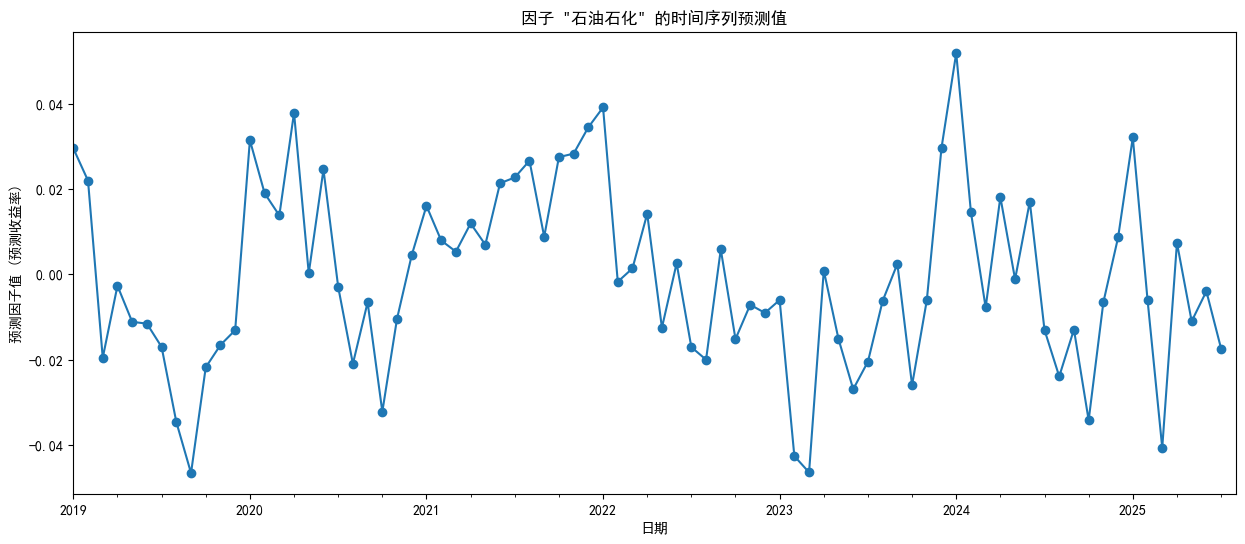

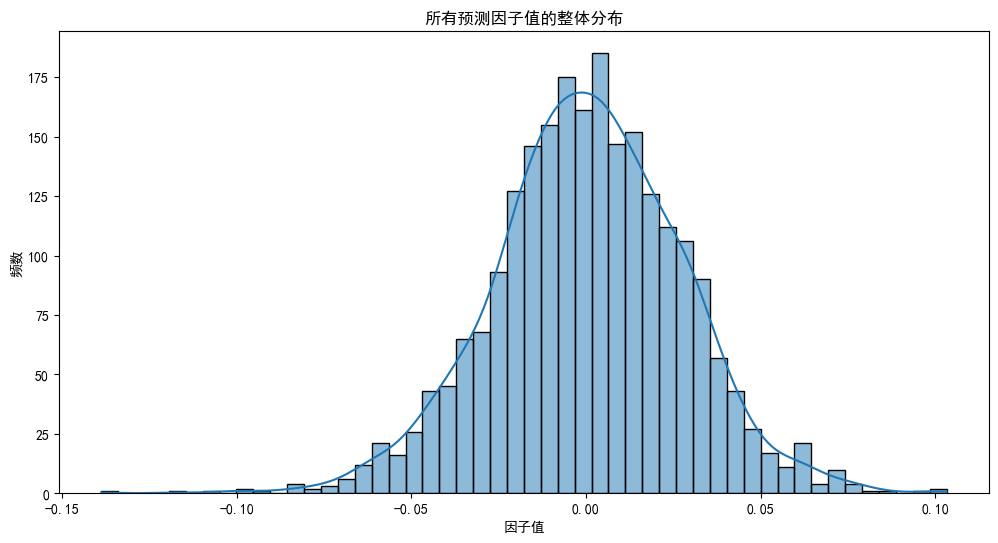

In [ ]:
# 检查填充后的 factor_value
print("填充后的 factor_value DataFrame:")
display(factor_value.head())
print("\n因子值描述性统计:")
display(factor_value.describe())

# 可视化单个因子的时间序列
# 选择一个您感兴趣的行业配对进行可视化
pair_to_plot = Y_data.columns[0] 
plt.figure(figsize=(15, 6))
factor_value[pair_to_plot].plot(marker='o', linestyle='-')
plt.title(f'因子 "{pair_to_plot}" 的时间序列预测值')
plt.xlabel('日期')
plt.ylabel('预测因子值 (预测收益率)')
plt.show()

# 可视化所有因子值的整体分布
plt.figure(figsize=(12, 6))
# 移除NaN值以防绘图报错
all_factors_flat = factor_value.values.flatten()
# all_factors_flat = all_factors_flat[~np.isnan(all_factors_flat)]

sns.histplot(all_factors_flat, bins=50, kde=True)
plt.title('所有预测因子值的整体分布')
plt.xlabel('因子值')
plt.ylabel('频数')
plt.show()

In [ ]:
# 保存因子值和模型参数到 Excel
output_filename = root_path_str + f'idx_factor_value/{model_name}_{window_kind}_lookback_{para}_{start_dt}_interval_{train_interval}.xlsx'
print(f"正在保存结果到: {output_filename}")

with pd.ExcelWriter(output_filename) as writer:
    roll_df_index(factor_value).to_excel(writer, sheet_name='因子值')
    macro_sensitivity.to_excel(writer, sheet_name='宏观模型')
    month_effect.to_excel(writer, sheet_name='月度效应')

print("结果保存完成。")

# 执行回测
print("\n开始执行回测...")
idx_factor = roll_df_index(factor_value)
idx_monthly_ror = pd.read_excel(root_path_str + 'data/idx_monthly_abs_ror.xlsx', index_col=0).dropna()

num_of_group = 5
start_time = start_dt
append_end_date = end_dt # 使用原始的结束日期进行回测

backtest_output_filename = output_filename.replace('.xlsx', f'_{num_of_group}分组_bt.xlsx')

output_backtest_table(idx_factor, idx_monthly_ror, num_of_group, start_time, append_end_date, None, '行业',
                      backtest_output_filename, None)

print(f"回测完成，结果已保存到: {backtest_output_filename}")

正在保存结果到: C:\Users\20560\Desktop\Code\idx_factor_value/linear_regression_expanding_lookback_6_20181231_interval_1.xlsx
结果保存完成。

开始执行回测...
回测完成，结果已保存到: C:\Users\20560\Desktop\Code\idx_factor_value/linear_regression_expanding_lookback_6_20181231_interval_1_5分组_bt.xlsx


正在从文件 'linear_regression_expanding_idx_factor_lookback_6_20181231_train_interval_1_5分组_bt.xlsx' 中读取数据...
所有工作表读取成功！

正在生成：分组累计净值曲线...


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


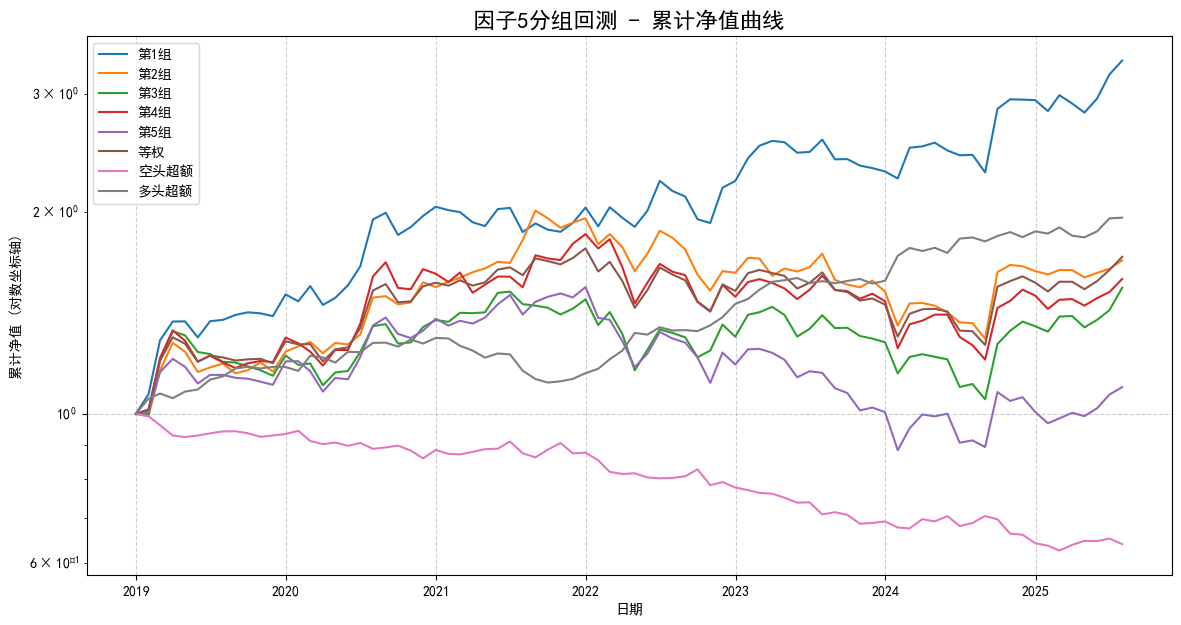

正在生成：核心评价指标对比图...


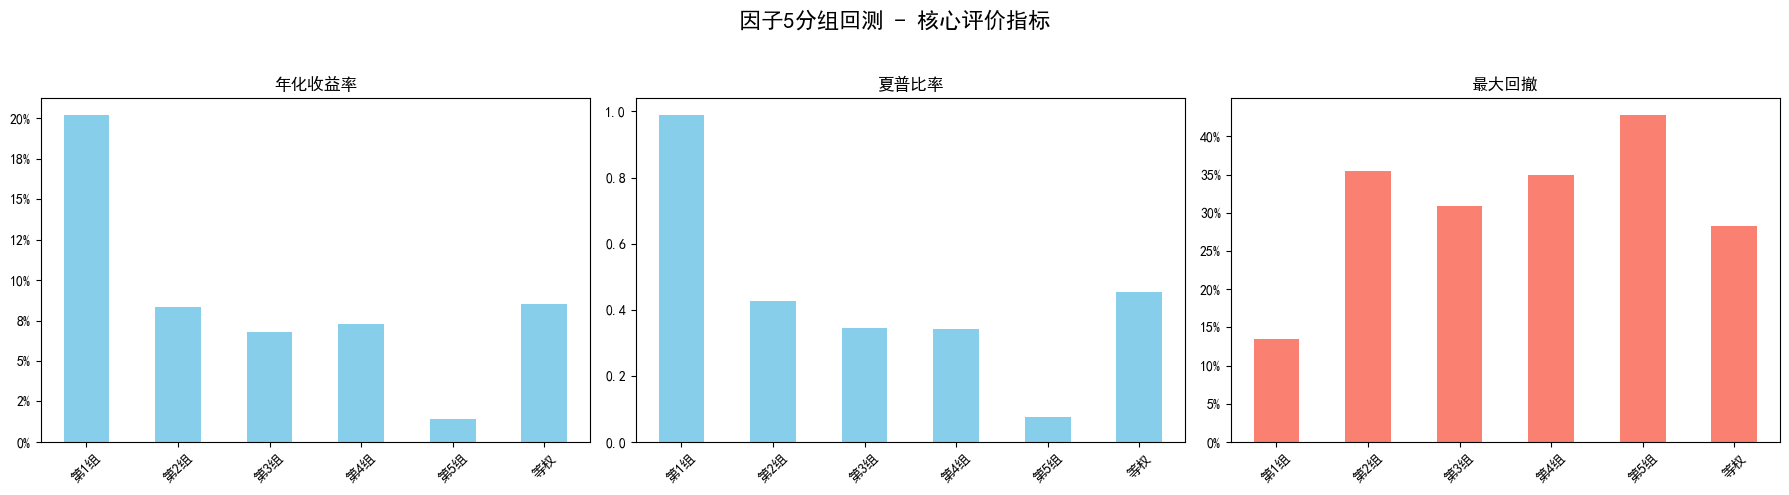

正在生成：分年度超额收益图...


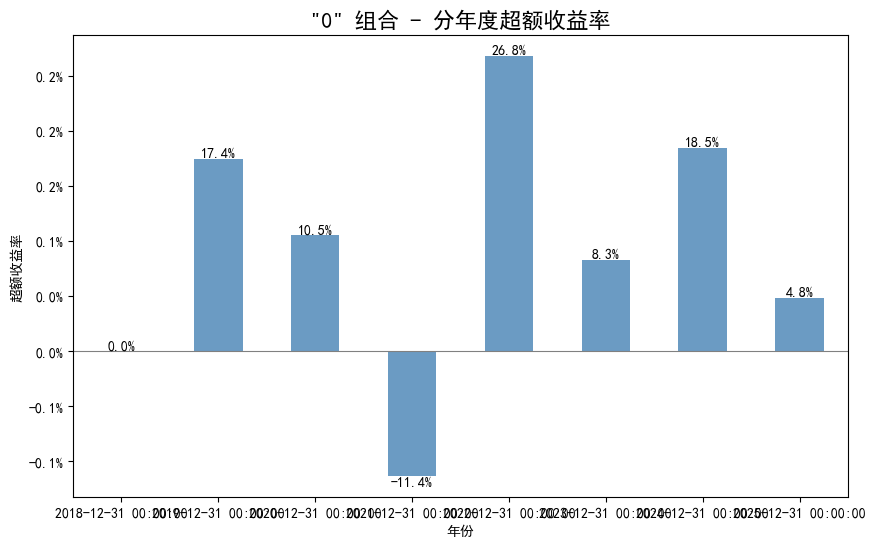

In [7]:
# 导入所需的库
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 全局绘图参数设置 ---
# 设置中文字体，以解决Matplotlib中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 定义要读取的Excel文件名 ---
excel_filename = 'linear_regression_expanding_idx_factor_lookback_6_20181231_train_interval_1_5分组_bt.xlsx'

# --- 2. 从Excel文件中读取不同的工作表 ---
try:
    print(f"正在从文件 '{excel_filename}' 中读取数据...")
    # 读取“组合净值”工作表
    df_net_value = pd.read_excel(
        excel_filename,
        sheet_name='组合净值',
        index_col=0,
        parse_dates=True
    )

    # 读取“评价指标”工作表
    df_metrics = pd.read_excel(
        excel_filename,
        sheet_name='评价指标',
        index_col=0
    )

    # 读取“分年超额”工作表
    df_annual_excess = pd.read_excel(
        excel_filename,
        sheet_name='分年超额',
        index_col=0
    )
    # 如果数据是带'%'的文本格式，将其转换为数值
    if df_annual_excess.iloc[:, 0].dtype == 'object':
        df_annual_excess = df_annual_excess.stack().str.strip('%').unstack().astype(float)

    print("所有工作表读取成功！")

    # --- 3. 可视化：分组累计净值曲线 ---
    print("\n正在生成：分组累计净值曲线...")
    plt.figure(figsize=(14, 7))
    for col in df_net_value.columns:
        plt.plot(df_net_value.index, df_net_value[col], label=col)

    plt.title('因子5分组回测 - 累计净值曲线', fontsize=16)
    plt.xlabel('日期')
    plt.ylabel('累计净值 (对数坐标轴)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.yscale('log')
    plt.savefig("backtest_net_value.png")
    plt.show()

    # --- 4. 可视化：核心评价指标对比 ---
    print("正在生成：核心评价指标对比图...")
    metrics_to_plot = ['年化收益率%', '夏普比率', '最大回撤%']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('因子5分组回测 - 核心评价指标', fontsize=16)

    for i, metric in enumerate(metrics_to_plot):
        data_to_plot = df_metrics[metric]
        if metric == '最大回撤%':
            data_to_plot = data_to_plot.abs()
        
        bar_color = 'salmon' if metric == '最大回撤%' else 'skyblue'
        bars = data_to_plot.plot(kind='bar', ax=axes[i], color=bar_color)
        axes[i].set_title(metric.replace('%',''))
        axes[i].tick_params(axis='x', rotation=45)

        if '%' in metric:
             axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("backtest_metrics.png")
    plt.show()
    
    # --- 5. 可视化：第1组分年度超额收益 ---
    print("正在生成：分年度超额收益图...")
    plt.figure(figsize=(10, 6))
    
    top_group_excess = df_annual_excess.iloc[:, 0]
    top_group_name = df_annual_excess.columns[0]
    
    bars = top_group_excess.plot(kind='bar', color='steelblue', alpha=0.8)
    plt.title(f'"{top_group_name}" 组合 - 分年度超额收益率', fontsize=16)
    plt.xlabel('年份')
    plt.ylabel('超额收益率')
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.xticks(rotation=0)
    
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1%}', 
                 ha='center', va='bottom' if yval >= 0 else 'top', color='black')

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))
    plt.savefig("annual_excess_return.png")
    plt.show()

except FileNotFoundError:
    print(f"文件读取失败，请确保文件 '{excel_filename}' 在同一目录下。")
except ValueError as e:
    print(f"读取Excel工作表时发生错误，请检查工作表名称是否正确：{e}")
except Exception as e:
    print(f"处理或绘图时发生未知错误: {e}")